In [97]:
%pylab --no-import-all
%matplotlib inline

pylab.rcParams['figure.figsize'] = (6,6)
# print pylab.rcParams.keys()
pylab.rcParams['image.cmap'] = 'gray'

import scipy.io as sio

data_raw = sio.loadmat('pendigits.mat')

xtrain, ytrain = data_raw['xtrain'].T, data_raw['ytrain'][0]
xtest, ytest = data_raw['xtest'].T, data_raw['ytest'][0]


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Show some examples

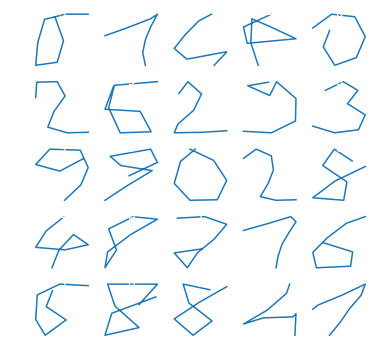

In [2]:
fig, ax = plt.subplots(5,5)

for idx in xrange(5):
  for jdx in xrange(5):
    num = np.random.randint(0, len(xtrain))
    x = xtrain[num][::2]
    y = xtrain[num][1::2]
    ax[idx][jdx].plot(x, y)
    ax[idx][jdx].grid('off')
    ax[idx][jdx].set_axis_off()
    ax[idx][jdx].set_title(str(ytrain[num]), color='w', y=0.8)
plt.show()

## "Hardness"

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

linear = LogisticRegression()
linear.fit(xtrain, ytrain)
print "Linear Score:", linear.score(xtrain, ytrain)

# polynomial = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression())
xtrain_poly = PolynomialFeatures(degree=2).fit_transform(xtrain)
polynomial = LogisticRegression()

polynomial = LogisticRegression()
polynomial.fit(xtrain_poly, ytrain)
print "Polynomial Score:", polynomial.score(xtrain_poly, ytrain)


Linear Score: 0.946757405925
Polynomial Score: 0.999866559915


In [4]:
y_linear = linear.predict(xtrain)
y_poly = polynomial.predict(xtrain_poly)

y_classifier = -np.ones(ytrain.shape)
y_classifier[y_linear != ytrain] = 1

print np.sum(y_classifier)

-6696.0


### What examples cannot be classified using a linear?

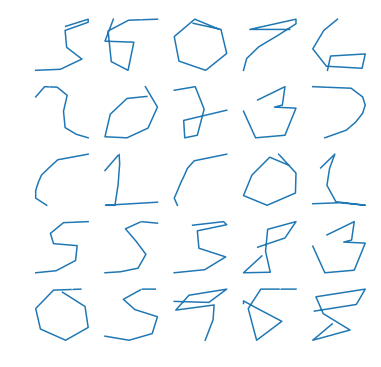

In [5]:
x_lin_wrong = xtrain[y_linear != ytrain]
y_lin_wrong = y_linear[y_linear != ytrain]
fig, ax = plt.subplots(5,5)
for idx in xrange(5):
  for jdx in xrange(5):
    num = np.random.randint(0, len(x_lin_wrong))
    x = x_lin_wrong[num][::2]
    y = x_lin_wrong[num][1::2]
    ax[idx][jdx].plot(x, y)
    ax[idx][jdx].grid('off')
    ax[idx][jdx].set_axis_off()
    ax[idx][jdx].set_title('T:' + str(ytrain[y_linear != ytrain][num]) + 
                           '/P:' + str(y_poly[y_linear != ytrain][num]) + 
                           '/L:' + str(y_linear[y_linear != ytrain][num]), color='w', y=0.9)
plt.show()

### Distance to decision boundary

In [29]:
decision_distance = linear.decision_function(xtrain)
## Distance to the second candidate
# dec = np.zeros(decision_distance.shape[0])
dec = []
for idx, x in enumerate(decision_distance):
  # print idx, x
  if sum(x > 0) == 1:
    # Only one true
    # dec.append(1.)
    pass
  else:
    x.sort()
    dec.append(np.abs((x[-1] - x[-2]) / (x[-1]+x[-2])))
# n, bins, patches = plt.hist(decision_distance, 50, normed=1, facecolor='green', alpha=0.75)

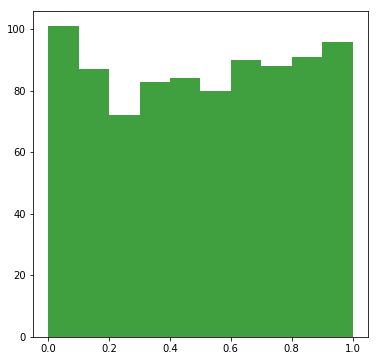

In [30]:
n, bins, patches = plt.hist(dec, 10, facecolor='green', alpha=0.75)

### Distance to decision boundary -- Attempt # 2
Let's use a synthetic dataset

In [21]:
x_axis = np.arange(-10, 10, 1e-2)
xx_axis = x_axis*x_axis
xxx_axis = xx_axis*x_axis

y_decision = .1 - .9*x_axis + .3*xx_axis - .7*xxx_axis
y_min, y_max = y_decision.min(), y_decision.max()
y_row = np.linspace(y_min, y_max, len(y_decision))

# print y_min, y_max
# print y_row.shape
y_rows = np.tile(y_row, (len(x_axis),1)).T
y_labels = np.ones(y_rows.shape)
y_labels[y_rows < y_decision] = -1
# print y_labels
# print y_labels.shape

samplex = np.random.randint(0, len(x_axis), int(0.3*len(x_axis)))
sampley = np.random.randint(0, len(y_decision), int(0.3*len(y_decision)))
samplelabel = y_labels[sampley, samplex]
samplex, sampley = x_axis[samplex], y_row[sampley]
samplefeatures = np.vstack((samplex, sampley)).T
print samplelabel.shape, samplefeatures.shape
# sampley = y_decision[sampley]
## Test:
testx = np.random.randint(0, len(x_axis), int(0.3*len(x_axis)))
testy = np.random.randint(0, len(y_decision), int(0.3*len(y_decision)))
testlabel = y_labels[testy, testx]
testx, testy = x_axis[testx], y_row[testy]
testfeatures = np.vstack((testx, testy)).T
print testlabel.shape, testfeatures.shape


(600,) (600, 2)
(600,) (600, 2)


In [206]:
## Training the linear
from sklearn.linear_model import LogisticRegression
linear = LogisticRegression()

linear.fit(samplefeatures, samplelabel)
print "Training score:", linear.score(samplefeatures, samplelabel)
print "Random re-sample score:", linear.score(testfeatures, testlabel)


a = -linear.coef_[0][0] / linear.coef_[0][1]
b = -linear.intercept_[0] / linear.coef_[0][1]
y_decision_prime = a*x_axis + b

y_labels_prime = np.ones(y_rows.shape)
y_labels_prime[y_rows < y_decision_prime] = -1

## use samplex, sampley to find the hard problems
samplelabel_prime = linear.predict(samplefeatures)
wrong = samplelabel_prime != samplelabel
samplex_prime, sampley_prime = samplex[wrong], sampley[wrong]
samplefeatures_prime = samplefeatures[wrong]

# print linear.decision_function(samplefeatures_prime)

hard_bias = np.max(np.abs(sampley_prime - a*samplex_prime - b))
# print hard_bias

y_decision_hard_up = y_decision_prime + hard_bias
y_decision_hard_down = y_decision_prime - hard_bias

y_labels_hard = -np.ones(y_rows.shape)
y_labels_hard[np.logical_and(y_rows < y_decision_hard_up, y_rows > y_decision_hard_down)] = 1

print linear.coef_, linear.intercept_

Training score: 0.943333333333
Random re-sample score: 0.93
[[ 0.74398803  0.01871351]] [-0.12427091]


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


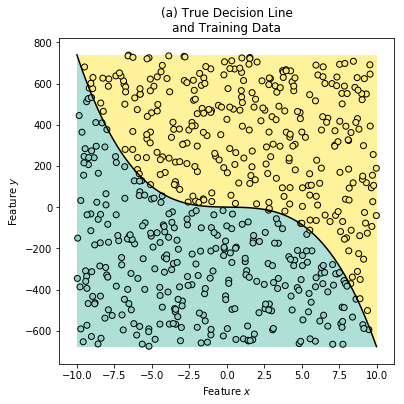

In [207]:
%pylab --no-import-all
%matplotlib inline

pylab.rcParams['figure.figsize'] = (6,6)
# print pylab.rcParams.keys()
pylab.rcParams['image.cmap'] = 'gray'

cmap = 'Set3'
textcol = 'k'

fig, ax = plt.subplots(1,1, sharey=True)

ax.imshow(
  y_labels, 
  interpolation='nearest', 
  aspect='auto', 
  origin='lower', 
  extent=[x_axis.min(), x_axis.max(), y_decision.min(), y_decision.max()], 
  cmap=cmap,  
  alpha=.7,)
ax.plot(x_axis, y_decision, color='k')
ax.scatter(samplex, sampley, c=samplelabel, cmap=cmap, edgecolors='k')
# ax[0].set_axis_off()
ax.set_ylabel('Feature $y$')
ax.set_xlabel('Feature $x$')
ax.set_title('(a) True Decision Line\nand Training Data', color=textcol)

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


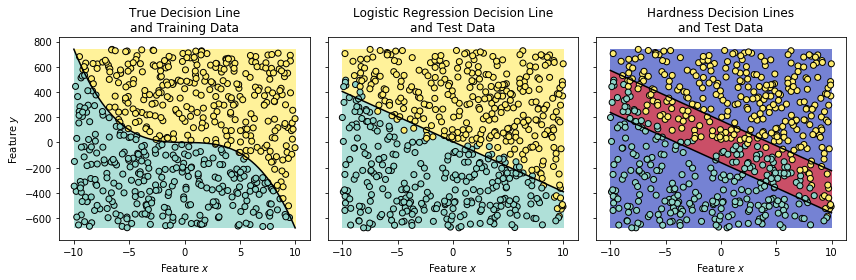

In [205]:
%pylab --no-import-all
%matplotlib inline

pylab.rcParams['figure.figsize'] = (12,4)
# print pylab.rcParams.keys()
pylab.rcParams['image.cmap'] = 'gray'

cmap = 'Set3'
textcol = 'k'

fig, ax = plt.subplots(1,3, sharey=True)

ax[0].imshow(
  y_labels, 
  interpolation='nearest', 
  aspect='auto', 
  origin='lower', 
  extent=[x_axis.min(), x_axis.max(), y_decision.min(), y_decision.max()], 
  cmap=cmap,  
  alpha=.7,)
ax[0].plot(x_axis, y_decision, color='k')
ax[0].scatter(samplex, sampley, c=samplelabel, cmap=cmap, edgecolors='k')
# ax[0].set_axis_off()
ax[0].set_ylabel('Feature $y$')
ax[0].set_xlabel('Feature $x$')
ax[0].set_title('(a) True Decision Line\nand Training Data', color=textcol)

ax[1].imshow(
  y_labels_prime, 
  interpolation='nearest', 
  aspect='auto', 
  origin='lower', 
  extent=[x_axis.min(), x_axis.max(), y_decision.min(), y_decision.max()], 
  cmap=cmap,  
  alpha=.7,)
ax[1].plot(x_axis, y_decision_prime, color='k')
ax[1].scatter(testx, testy, c=testlabel, cmap=cmap, edgecolors='k')
# ax[1].set_axis_off()
# ax[1].set_ylabel('Feature $y$')
ax[1].set_xlabel('Feature $x$')
ax[1].set_title('(b) Logistic Regression Decision Line\nand Test Data', color=textcol)

ax[2].imshow(
  y_labels_hard, 
  interpolation='nearest', 
  aspect='auto', 
  origin='lower', 
  extent=[x_axis.min(), x_axis.max(), y_decision.min(), y_decision.max()], 
  cmap='coolwarm',  
  alpha=.7,)
# ax[2].plot(x_axis, y_decision_prime, color='k')
ax[2].plot(x_axis, y_decision_hard_up, color='k')
ax[2].plot(x_axis, y_decision_hard_down, color='k')
ax[2].scatter(testx, testy, c=testlabel, cmap=cmap, edgecolors='k')
# ax[2].set_axis_off()
# ax[2].set_ylabel('Feature $y$')
ax[2].set_xlabel('Feature $x$')
ax[2].set_title('(c) Hardness Decision Lines\nand Test Data', color=textcol)
fig.tight_layout()

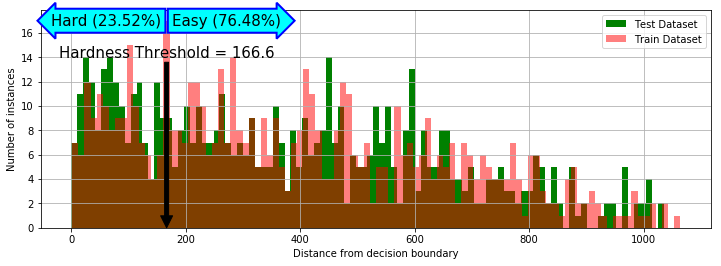

In [199]:
## Distance to the decision line
## use samplex, sampley to find the hard problems
# samplelabel_prime = linear.predict(samplefeatures)
# wrong = samplelabel_prime != samplelabel
# samplex_prime, sampley_prime = samplex[wrong], sampley[wrong]
# samplefeatures_prime = samplefeatures[wrong]

# print linear.decision_function(samplefeatures_prime)

distance = np.abs(testy - a*testx - b)
n1, bins1, patches1 = plt.hist(distance, 100, facecolor='green', label="Test Dataset")
n2, bins2, patches1 = plt.hist(np.abs(sampley - a*samplex - b), 100, facecolor='red', alpha=0.5, label="Train Dataset")
# plt.plot([hard_bias, hard_bias], [0,20], '--k', linewidth=5, label="Hardness Threshold = %.1f"%hard_bias)
plt.legend()
# plt.yticks([])
plt.grid()
plt.xlabel("Distance from decision boundary")
plt.ylabel("Number of instances")

hard = np.sum(y_labels_hard == 1) / np.float(len(y_labels_hard)*len(y_labels_hard[0]))
easy = 1 - hard

# plt.text(0, 17.5, '%.1f%%'%(hard*100), fontsize=16)

bbox_props = dict(boxstyle="larrow,pad=0.3", fc="cyan", ec="b", lw=2)
plt.text(hard_bias-10, 17, "Hard (%.2f%%)"%(hard*100), ha="right", va="center", rotation=0,
            size=15,
            bbox=bbox_props)

bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=2)
plt.text(hard_bias+10, 17, "Easy (%.2f%%)"%(easy*100), ha="left", va="center", rotation=0,
            size=15,
            bbox=bbox_props)


plt.annotate("Hardness Threshold = %.1f"%hard_bias, xy=(hard_bias, 0), xytext=(hard_bias, 14),
            arrowprops=dict(facecolor='black', shrink=0.0),
            ha='center', size=15
            )